Kết nối với Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Khai báo các thư viện cần thiết

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


Khai báo đường dẫn để lấy dữ liệu

In [3]:
train_images_path = '/content/gdrive/MyDrive/Part_2_Third_Year/Machine learning/Final_Exam/data/train-images-idx3-ubyte.gz'
train_labels_path = '/content/gdrive/MyDrive/Part_2_Third_Year/Machine learning/Final_Exam/data/train-labels-idx1-ubyte.gz'
test_labels_path = '/content/gdrive/MyDrive/Part_2_Third_Year/Machine learning/Final_Exam/data/t10k-labels-idx1-ubyte.gz'
test_images_path = '/content/gdrive/MyDrive/Part_2_Third_Year/Machine learning/Final_Exam/data/t10k-images-idx3-ubyte.gz'

Xây dựng hàm đọc dữ liệu từ file 

In [4]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
  """
  This shuffle param is active when .gz is downloaded at:
  - 'http://yann.lecun.com/exdb/mnist/'
  - This function return random num_images in 60000 or 10000
  """
  # read data
  import gzip # to decompress gz (zip) file
  # open file training to read training data
  f_images = gzip.open(images_path,'r')
  # skip 16 first bytes because these are not data, only header infor
  f_images.read(16)
  # general: read num_images data samples if this parameter is set;
  # if not, read all (60000 training or 10000 test)
  real_num = num_images if not shuffle else (60000 if _is else 10000)
  # read all data to buf_images (28x28xreal_num)
  buf_images = f_images.read(image_size * image_size * real_num)
  # images
  images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
  images = images.reshape(real_num, image_size, image_size,)
  # Read labels
  f_labels = gzip.open(labels_path,'r')
  f_labels.read(8)

  labels = np.zeros((real_num)).astype(np.int64)
  # rearrange to correspond the images and labels
  for i in range(0, real_num):
    buf_labels = f_labels.read(1)
    labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
    
    # shuffle to get random images data
  if shuffle is True:
    rand_id = np.random.randint(real_num, size=num_images)
    images = images[rand_id, :]
    labels = labels[rand_id,]
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
  return images, labels

Lấy dữ liệu và chia tập dữ liệu

In [5]:
train_images, train_labels = get_mnist_data(train_images_path, train_labels_path, 60000, shuffle=True)
test_images, test_labels = get_mnist_data(test_images_path, test_labels_path, 10000, _is=False, shuffle=True)
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


Ta muốn có 3 tập dữ liệu, train, validation and test. Vậy nên ta sẽ gộp 2 bộ train và test ban đầu lại và tách thành 3 bộ

In [52]:
# Combine train and test data
all_images = np.concatenate([train_images, test_images], axis=0)
all_labels = np.concatenate([train_labels, test_labels], axis=0)

# Shuffle combined data
np.random.seed(42)
shuffle_idx = np.random.permutation(len(all_images))
all_images = all_images[shuffle_idx]
all_labels = all_labels[shuffle_idx]

# Split into train, test, and validation sets
train_split = 0.8
val_split = 0.1
test_split = 0.1

num_examples = len(all_images)
num_train = int(train_split * num_examples)
num_val = int(val_split * num_examples)

train_images = all_images[:num_train]
train_labels = all_labels[:num_train]

val_images = all_images[num_train:num_train+num_val]
val_labels = all_labels[num_train:num_train+num_val]

test_images = all_images[num_train+num_val:]
test_labels = all_labels[num_train+num_val:]

print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)
print(test_images.shape, test_labels.shape)


(44800, 784) (44800,)
(5600, 784) (5600,)
(5600, 784) (5600,)


Hiển thị một số ví dụ

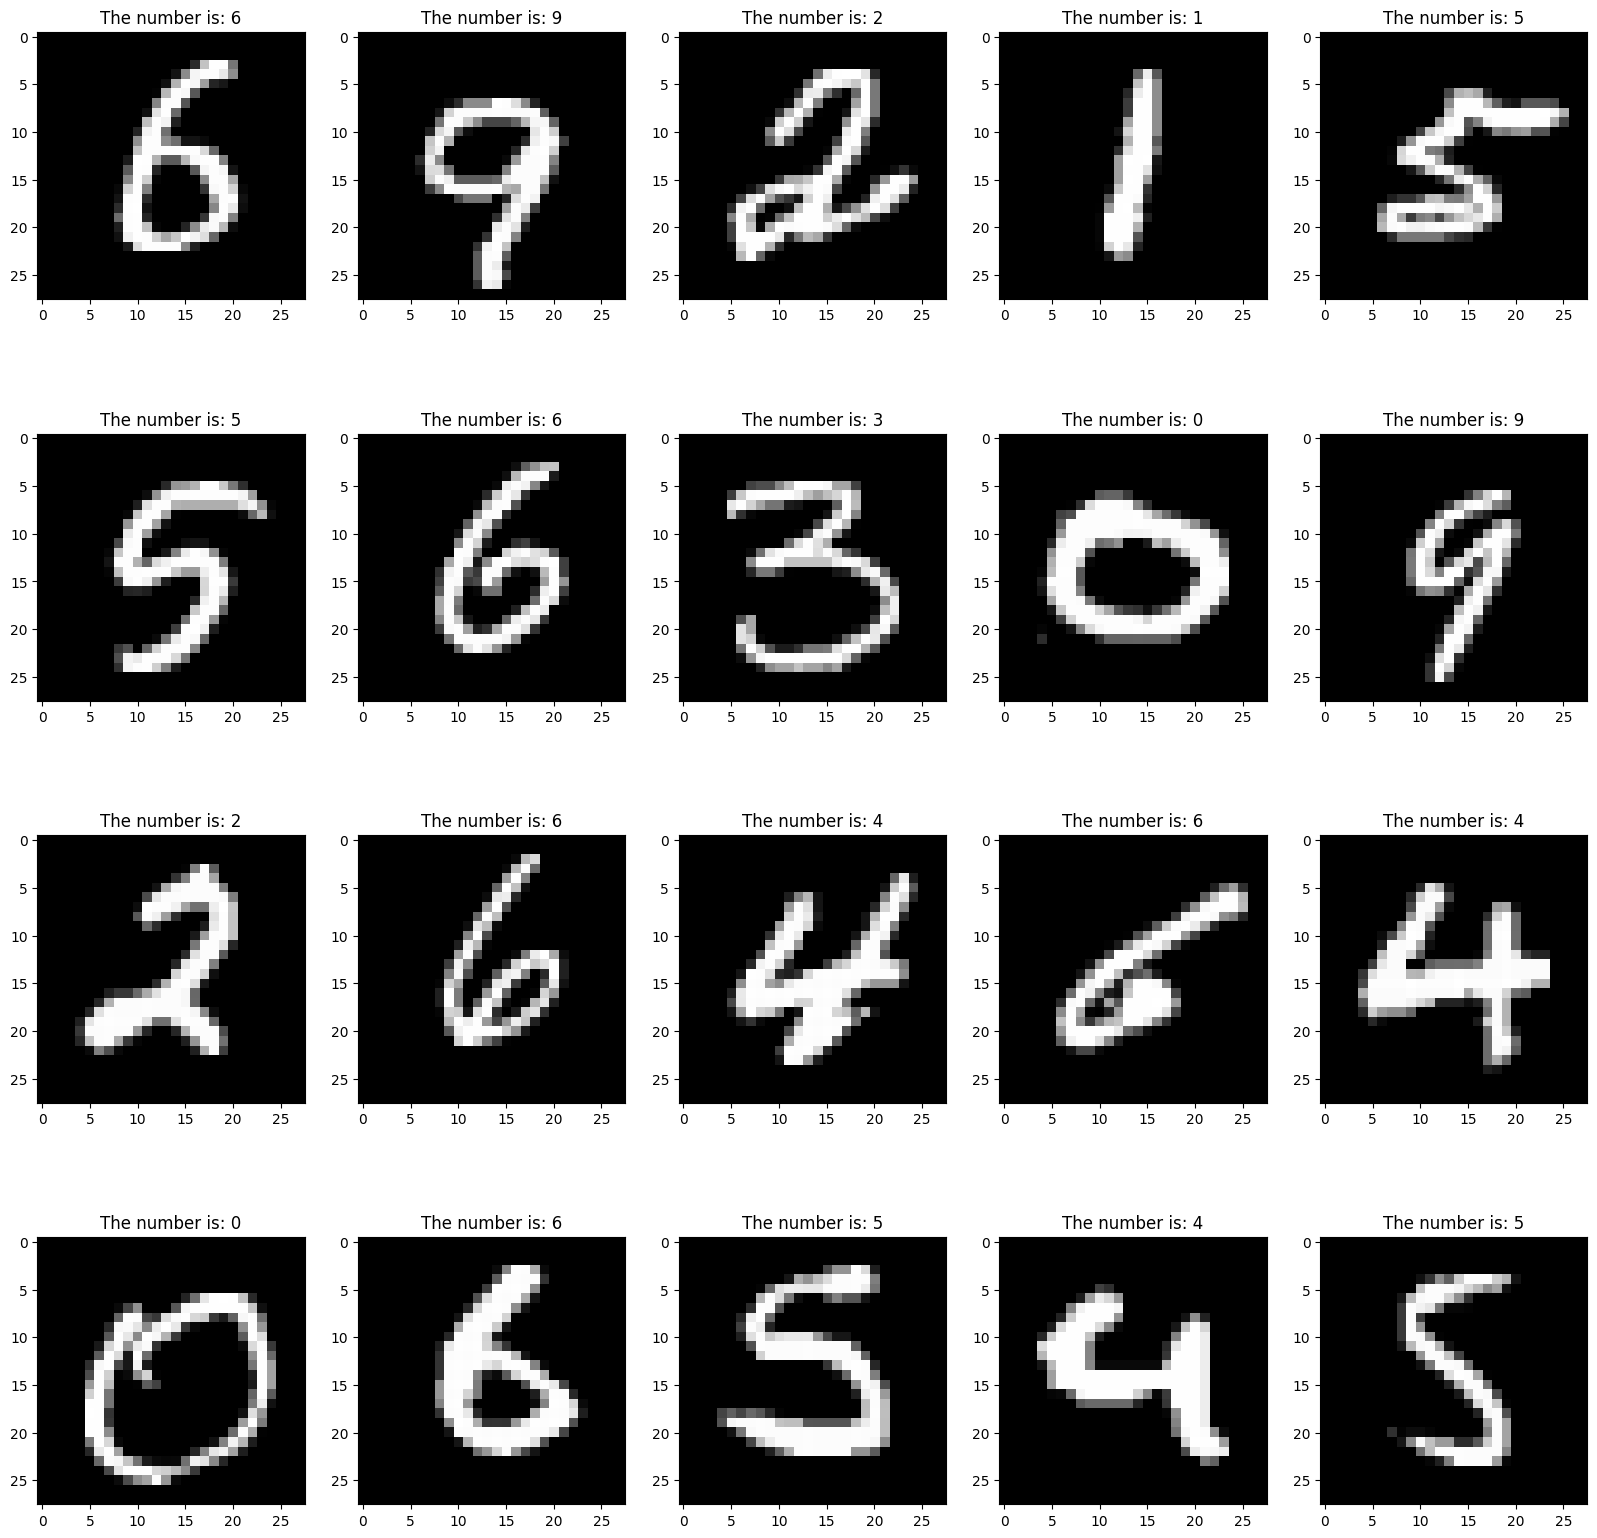

In [53]:
fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (20,20))
for i in range(4):
  for j in range(5):
    idx = np.random.randint(10000)
    ax[i][j].imshow(train_images[idx].reshape(28,28), cmap='gray')
    ax[i][j].set_title(f'The number is: {train_labels[idx]}')
plt.show()


Đưa ảnh về kích thước 28x28 và chuẩn hóa pixel của ảnh về khoảng (0,1)

In [55]:
train_images.shape[0]

44800

In [72]:
# Phần này
X_train = train_images.reshape((train_images.shape[0], 28, 28, 1))
X_train = X_train.astype('float32') / 255

X_valid = val_images.reshape((val_images.shape[0], 28, 28, 1))
X_valid = X_valid.astype('float32') / 255

X_test = test_images.reshape((test_images.shape[0], 28, 28, 1))
X_test = X_test.astype('float32') / 255


Mã hóa phân loại nhãn về dạng one-hot vector

In [95]:
# One-hot vector của ta sẽ là một ma trận gồm 10 cột (tương ứng 1o giá trị của nhãn), và số hàng cùng số lượng giá trị
# Nhãn có giá trị thì ở dạng one-hot vector sẽ được đánh số 1 ở vị trí tương ứng, các vị trí khác trong hàng sẽ để đánh số 0
y_train = tf.keras.utils.to_categorical(train_labels)
y_valid = tf.keras.utils.to_categorical(val_labels)
y_test = tf.keras.utils.to_categorical(test_labels)

In [73]:
# Ta in ra kiểm tra xem số lượng dữ liệu có bị thay đổi sau quá trình chuẩn hóa không
print("Training Images:", X_train.shape)
print('Validation Images:', X_valid.shape)
print('-' * 10)
print("Testing Images:", X_test.shape)
print("Training Labels:", y_train.shape)
print('-' * 10)
print("Validation Images:", X_valid.shape)
print("Test Labels:", y_test.shape)

Training Images: (44800, 28, 28, 1)
Validation Images: (5600, 28, 28, 1)
----------
Testing Images: (5600, 28, 28, 1)
Training Labels: (44800, 10)
----------
Validation Images: (5600, 28, 28, 1)
Test Labels: (5600, 10)


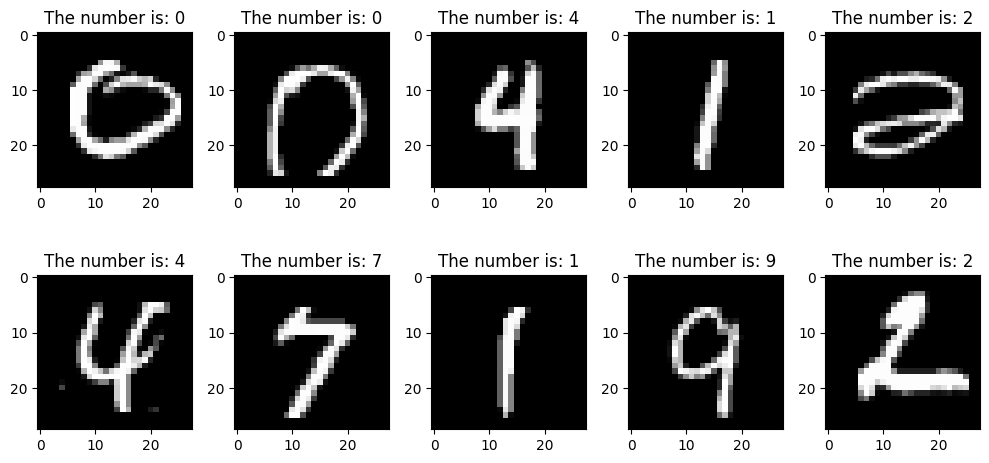

In [67]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,5))
for i in range(2):
  for j in range(5):
    idx = np.random.randint(10000)
    ax[i][j].imshow(X_train[idx], cmap='gray')
    ax[i][j].set_title(f'The number is: {train_labels[idx]}')
plt.tight_layout()
plt.show()


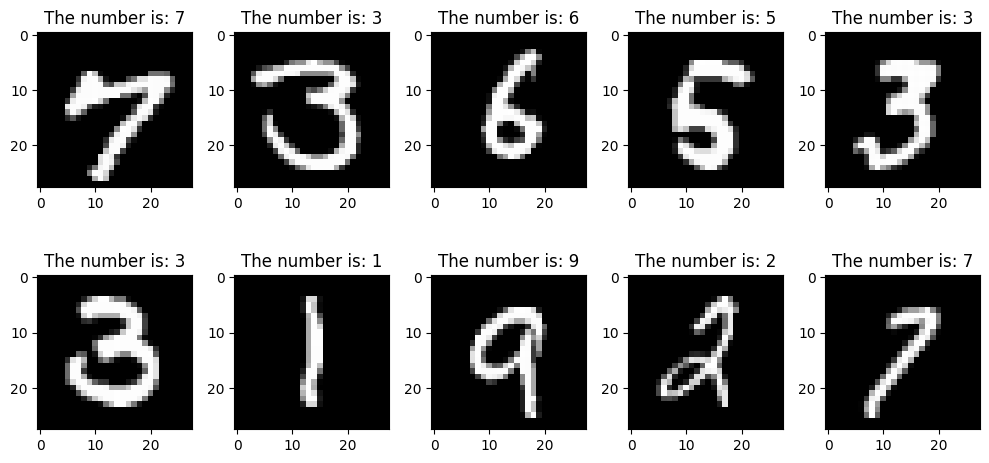

In [75]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,5))
for i in range(2):
  for j in range(5):
    idx = np.random.randint(X_valid.shape[0])
    ax[i][j].imshow(X_valid[idx], cmap='gray')
    ax[i][j].set_title(f'The number is: {val_labels[idx]}')
plt.tight_layout()
plt.show()


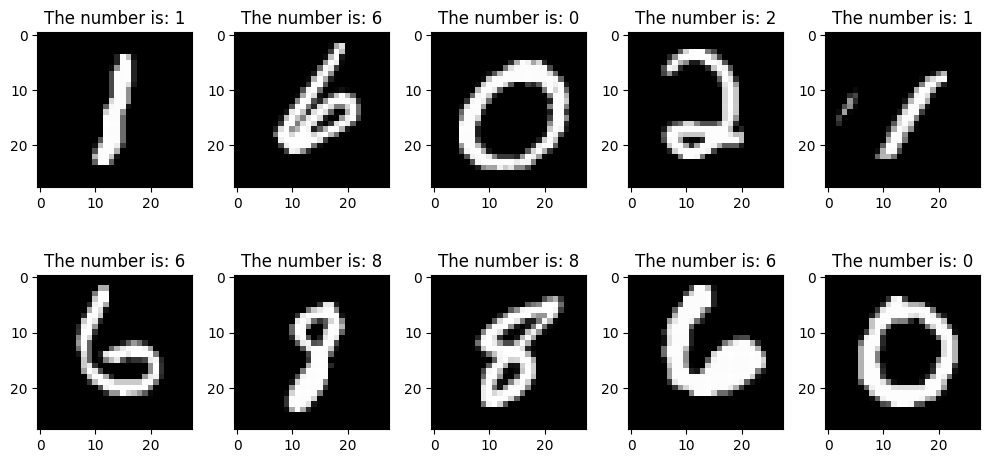

In [76]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,5))
for i in range(2):
  for j in range(5):
    idx = np.random.randint(X_test.shape[0])
    ax[i][j].imshow(X_test[idx], cmap='gray')
    ax[i][j].set_title(f'The number is: {test_labels[idx]}')
plt.tight_layout()
plt.show()


Lấy số chiều của ảnh và số lượng lớp

In [77]:
idx,width, height, channel = X_train[:0].shape
num_classes = len(y_train[0])

print('width, height, channel:',width, height, channel)
print('classes: ',num_classes)

width, height, channel: 28 28 1
classes:  10


## Convolutional Neural Network (CNN)

In [84]:
def cnn_block(layer, filters_num,kernel_size, strides, kernel_ini, padding,\
               dropout_rate, name_index, pooling = True, batnorm = True):
    layer = layers.Conv2D(
        filters=filters_num, 
        kernel_size = kernel_size,
        strides=strides,
        activation='relu',
        kernel_initializer = kernel_ini,
        padding = padding, 
        name=f'block_Conv{name_index}' 
    )(layer)

    if not pooling:
        layer = layers.BatchNormalization(name=f'block_batch{name_index}')(layer)
        return layers.Dropout(rate=dropout_rate)(layer)
    if not batnorm:
        layer = layers.Dropout(rate=dropout_rate)(layer)
        return layers.MaxPooling2D((2,2), name=f'block_maxpool{name_index}')(layer)
    layer = layers.BatchNormalization(name=f'block_batch{name_index}')(layer)
    layer = layers.Dropout(rate=dropout_rate)(layer)

    return layers.MaxPooling2D((2,2), name=f'block_maxpool{name_index}')(layer)

def build_model():
  input_img = tf.keras.Input(shape=(width, height, channel), name="image")
  layer = cnn_block(input_img, 32,(5,5), (1, 1),  "he_normal", "same", 0.2, 1, batnorm = False, pooling = False)
  layer = cnn_block(layer, 32,(3,3), (1, 1), "he_normal", "same", 0.2, 2, batnorm = False)

  layer = cnn_block(layer, 64,(5,5), (1, 1), "he_normal", "same", 0.2, 3)
  layer = cnn_block(layer, 64,(3,3),  (1, 1),"he_normal", "same", 0.2, 4, pooling = False)
  layer = cnn_block(layer, 64,(3,3),  (1, 1),"he_normal", "same", 0.2, 5)

  layer = layers.Flatten()(layer)
  layer = layers.Dropout(0.3)(layer)
  layer = layers.Dense(64, activation='relu', name='dense1')(layer)
  layer = layers.Dropout(0.3)(layer)
  layer = layers.Dense(32, activation='relu', name='dense2')(layer)
  output = layers.Dense(num_classes, activation='softmax', name='output')(layer)
  model = tf.keras.models.Model(inputs=input_img, outputs=output)
  return model



Ta tiến hành thiết lập cấu trúc mạng của ta

In [85]:
model = build_model()

In [86]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 block_Conv1 (Conv2D)        (None, 28, 28, 32)        832       
                                                                 
 block_batch1 (BatchNormaliz  (None, 28, 28, 32)       128       
 ation)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 block_Conv2 (Conv2D)        (None, 28, 28, 32)        9248      
                                                                 
 dropout_22 (Dropout)        (None, 28, 28, 32)        0         
                                                           

In [96]:
# Compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adam'
), loss='categorical_crossentropy', metrics=['accuracy'])

## Huấn luyện mô hình

In [97]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='/content/gdrive/MyDrive/Part_2_Third_Year/Machine learning/Final_Exam/tensor_board/')
# Define the parameters.
num_epochs = 100
batch_size = 64

best_model = ModelCheckpoint(filepath='/content/gdrive/MyDrive/Part_2_Third_Year/Machine learning/Final_Exam/model_saved/best_model_1.hdf5', monitor='val_loss', verbose=1,save_weights_only = False,save_best_only=True, mode="min")
# Train the model.
history = model.fit(X_train, 
                      y_train, 
                      epochs=num_epochs, 
                      batch_size=batch_size, 
                      validation_data=(X_valid, y_valid),
                      callbacks=[best_model,tensorboard])

Epoch 1/100
698/700 [============================>.] - ETA: 0s - loss: 1.7499 - accuracy: 0.3996
Epoch 1: val_loss improved from inf to 0.64631, saving model to /content/gdrive/MyDrive/Part_2_Third_Year/Machine learning/Final_Exam/model_saved/best_model_1.hdf5
700/700 [==============================] - 14s 9ms/step - loss: 1.7473 - accuracy: 0.4005 - val_loss: 0.6463 - val_accuracy: 0.8505
Epoch 2/100
700/700 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.7993
Epoch 2: val_loss improved from 0.64631 to 0.25054, saving model to /content/gdrive/MyDrive/Part_2_Third_Year/Machine learning/Final_Exam/model_saved/best_model_1.hdf5
700/700 [==============================] - 7s 10ms/step - loss: 0.6081 - accuracy: 0.7993 - val_loss: 0.2505 - val_accuracy: 0.9357
Epoch 3/100
697/700 [============================>.] - ETA: 0s - loss: 0.3306 - accuracy: 0.8978
Epoch 3: val_loss improved from 0.25054 to 0.18310, saving model to /content/gdrive/MyDrive/Part_2_Third_Year/Mac

In [98]:
PATH_MODEL = r'/content/gdrive/MyDrive/Part_2_Third_Year/Machine learning/Final_Exam/model_saved/model_1.hdf5'

## Hiển thị ma trận và chỉ số accuracy

In [99]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

175/175 [==============================] - 1s 3ms/step - loss: 0.0178 - accuracy: 0.9964
Test Accuracy: 0.9964285492897034
Test Loss: 0.0177526343613863


In [100]:
# Save the metrics.
metrics = history.history

In [101]:
# Save the loss values.
training_loss_list = metrics['loss']
test_loss_list = metrics['val_loss']

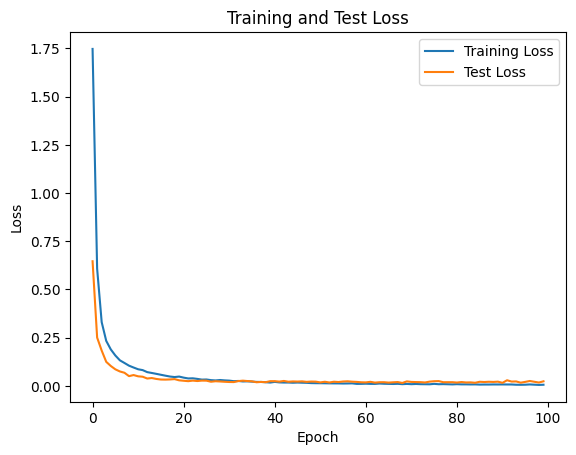

In [102]:
# Plot the training and test loss.
x = np.arange(0, num_epochs, 1)
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, training_loss_list, label='Training Loss')
plt.plot(x, test_loss_list, label='Test Loss')
plt.legend()
plt.show()

In [103]:
train_accuracy_list = metrics['accuracy']
test_accuracy_list = metrics['val_accuracy']

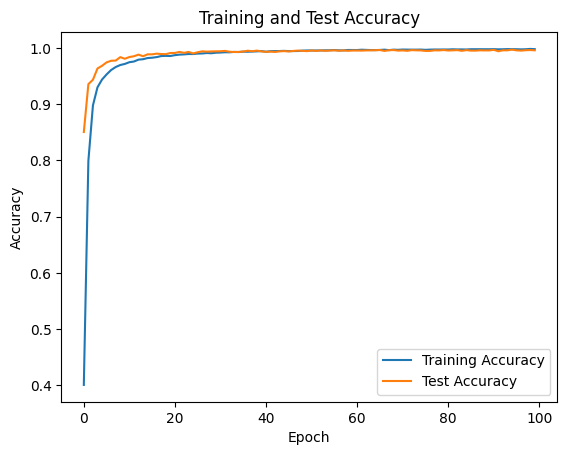

In [104]:
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_accuracy_list, label='Training Accuracy')
plt.plot(x, test_accuracy_list, label='Test Accuracy')
plt.legend()
plt.show()

## Dự đoán

In [105]:
# Make predictions with the trained model.
predictions = model.predict(X_test)

175/175 [==============================] - 1s 2ms/step


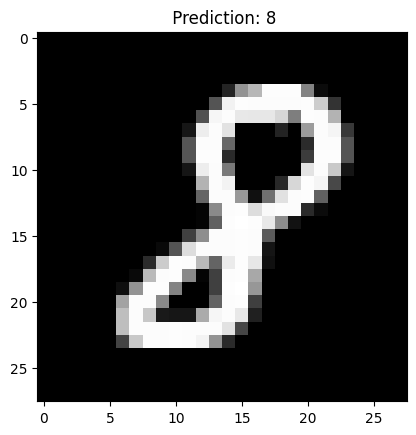

In [108]:
# Choose an index.
index = np.random.randint(X_test.shape[0])
predict_label = np.argmax(predictions[index])
# Show an image from the test set.
plt.imshow(X_test[index], cmap='gray')
plt.title(f' Prediction: {predict_label}')
plt.show()

Tải lại model đã lưu để chạy

In [109]:
loaded_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Part_2_Third_Year/Machine learning/Final_Exam/model_saved/best_model_1.hdf5')
# Compile the model (if needed)
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [110]:

# Evaluate the model on a test dataset
test_loss, test_acc = loaded_model.evaluate(X_test, y_test, verbose=2)



175/175 - 1s - loss: 0.0163 - accuracy: 0.9955 - 732ms/epoch - 4ms/step


In [111]:
# Make predictions using the model
loaded_predictions = loaded_model.predict(X_test)

175/175 [==============================] - 0s 2ms/step


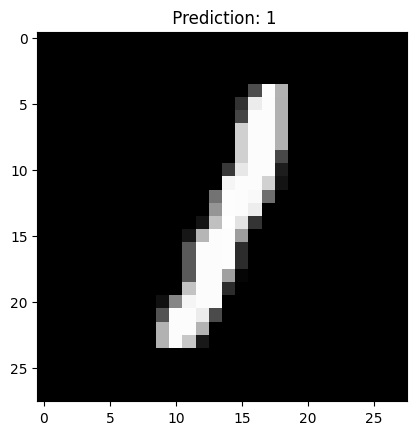

In [114]:
# Choose an index.
index = np.random.randint(10000)
predict_label = np.argmax(loaded_predictions[index])
# Show an image from the test set.
plt.imshow(X_test[index], cmap='gray')
plt.title(f' Prediction: {predict_label}')
plt.show()